In [2]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\btada/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\btada/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
# %% Import Required Libraries
import pandas as pd
import duckdb
import nltk
import random
import numpy as np
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from xgboost import XGBRegressor
import pandas_market_calendars as mcal
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.inspection import permutation_importance
from tabulate import tabulate

# %% Download NLTK Resources
nltk.download('stopwords')
nltk.download('punkt_tab')

# %% Database Connection
db_path = r'C:\Users\btada\Documents\financial_news.db'
conn = duckdb.connect(database=db_path, read_only=False)

# %% Load Stopwords
stop_words = set(stopwords.words('english'))

# %% Get All Available Tickers & Sample a Subset
query_tickers = "SELECT DISTINCT ticker FROM Headlines.Articles_Trading_Day"
ticker_df = conn.execute(query_tickers).fetchdf()

# Randomly sample 20 tickers for testing
ticker_all = random.sample(list(ticker_df["ticker"]), 20)

# %% Load Loughran-McDonald Dictionary for High-Risk Words
lm_dict_path = r"C:\Users\btada\Documents\Loughran-McDonald_MasterDictionary_1993-2023.csv"
lm_dict = pd.read_csv(lm_dict_path)
high_risk_words = set(lm_dict[lm_dict["Negative"] > 0]["Word"].str.lower())

# %% Load NYSE Trading Calendar
nyse = mcal.get_calendar('NYSE')

# %% Query Sentiment Analysis Data
sentiment_analysis = conn.execute("SELECT * FROM Headlines.finbert_analysis").fetchdf()

# %% Define Helper Functions

# Get next trading day
def next_trading_day(date):
    date = pd.Timestamp(date)
    while len(nyse.valid_days(start_date=date.strftime('%Y-%m-%d'), end_date=date.strftime('%Y-%m-%d'))) == 0:
        date += pd.Timedelta(days=1)
    return date

# Tokenize text and count high-risk words
def tokenize_text(text):
    words = word_tokenize(text.lower())
    words = [word for word in words if word.isalpha() and len(word) > 2 and word not in stop_words]
    high_risk_count = sum(1 for word in words if word in high_risk_words)
    return words, high_risk_count

# Clean NaN data before modeling
def clean_data(X, y):
    """Removes rows where y is NaN."""
    mask = ~np.isnan(y) & ~np.isnan(X).any(axis=1) # Keep only non-NaN values
    return X[mask], y[mask]

# **Feature Importance for Tree-Based Models**
def evaluate_feature_importance(models, X_train, X_test, y_test):
    """
    Computes and prints feature importance for different models.
    """
    feature_names = [
        "token_score", "high_risk_count", "finbert_title_score", "finbert_description_score",
        "finbert_title_positive", "finbert_title_neutral", "finbert_title_negative",
        "finbert_description_positive", "finbert_description_neutral", "finbert_description_negative"
    ]

    # **Feature Importance for Tree-Based Models**
    tree_models = ["Random Forest", "XGBoost"]
    feature_importances = {}

    for name in tree_models:
        if name in models and hasattr(models[name], "feature_importances_"):
            feature_importances[name] = models[name].feature_importances_

    if feature_importances:
        feature_importance_df = pd.DataFrame(feature_importances, index=feature_names)
        feature_importance_df.sort_values(by="Random Forest", ascending=False, inplace=True)

        print("\n📊 **Tree-Based Model Feature Importance**")
        print(tabulate(feature_importance_df, headers="keys", tablefmt="psql"))

    # **Ridge Regression Coefficients**
    if "Linear Regression" in models:
        ridge_coefficients = models["Linear Regression"].coef_
        ridge_coeff_df = pd.DataFrame({"Feature": feature_names, "Coefficient": ridge_coefficients})
        ridge_coeff_df.sort_values(by="Coefficient", ascending=False, inplace=True)

        print("\n📊 **Linear Regression Coefficients**")
        print(tabulate(ridge_coeff_df, headers="keys", tablefmt="psql"))

    # **Permutation Importance for Neural Network**
    if "Neural Network" in models:
        mlp_perm_importance = permutation_importance(models["Neural Network"], X_test, y_test, n_repeats=10, random_state=42)

        mlp_importance_df = pd.DataFrame(
            {"Feature": feature_names, "Importance": mlp_perm_importance.importances_mean}
        )
        mlp_importance_df.sort_values(by="Importance", ascending=False, inplace=True)

        print("\n📊 **MLP Permutation Importance**")
        print(tabulate(mlp_importance_df, headers="keys", tablefmt="psql"))

# %% Function to Process a Single Ticker
def process_ticker(ticker, conn, nyse, sentiment_df, result_df):
    print(f"Processing {ticker}...")

    # Query financial news, sentiment, and stock price movement
    query = """
        SELECT 
            a.mapped_trading_date AS publish_date,
            a.description, 
            dpm.price_change_percentage,
            f.finbert_title_label,
            f.finbert_title_score,
            f.finbert_title_positive,
            f.finbert_title_neutral,
            f.finbert_title_negative,
            f.finbert_description_label,
            f.finbert_description_score,
            f.finbert_description_positive,
            f.finbert_description_neutral,
            f.finbert_description_negative
        FROM "Headlines"."Articles_Trading_Day" a
        INNER JOIN "Headlines"."Daily_Price_Movement" dpm
            ON a.mapped_trading_date = dpm.trading_date  
        INNER JOIN "Headlines"."finbert_analysis" f
            ON a.guid = f.guid
        WHERE a.ticker = ?
        AND dpm.ticker = ?;
    """
    
    news_df = conn.execute(query, [ticker, ticker]).fetchdf()

    if news_df.empty:
        #print(f"⚠️ Skipping {ticker}: No data found.")
        return None  # ✅ Return None if no data

    # Process dates and group descriptions
    news_df["publish_date"] = pd.to_datetime(news_df["publish_date"]).dt.date
    news_df["description"] = news_df["description"].fillna("")
    news_df = news_df.groupby("publish_date", as_index=False).agg({
        "description": lambda x: " ".join(x),
        "price_change_percentage": "first",
        "finbert_title_score": "mean",
        "finbert_description_score": "mean",
        "finbert_title_positive": "mean",
        "finbert_title_neutral": "mean",
        "finbert_title_negative": "mean",
        "finbert_description_positive": "mean",
        "finbert_description_neutral": "mean",
        "finbert_description_negative": "mean",
    })

    # Adjust for non-trading days
    news_df["adjusted_date"] = news_df["publish_date"].apply(next_trading_day)

    # Tokenization and High-Risk Word Detection
    news_df["tokenized_words"], news_df["high_risk_count"] = zip(*news_df["description"].apply(tokenize_text))

    # Compute Token Score
    word_scores = {word: [] for word in set(word for words_list in news_df["tokenized_words"] for word in words_list)}
    for _, row in news_df.iterrows():
        words_list = row["tokenized_words"]
        price_change = row["price_change_percentage"]
        total_words = len(words_list)
        if total_words > 0:
            word_counts = {word: words_list.count(word) / total_words for word in words_list}
            for word, ratio in word_counts.items():
                word_scores[word].append(ratio * price_change)

    token_scores_dict = {word: np.mean(scores) if scores else 0 for word, scores in word_scores.items()}
    news_df["token_score"] = news_df["tokenized_words"].apply(lambda tokens: sum(token_scores_dict.get(token, 0) for token in tokens))

    # Feature Engineering
    X = news_df[[ 
        "token_score", 
        "high_risk_count", 
        "finbert_title_score", 
        "finbert_description_score", 
        "finbert_title_positive",
        "finbert_title_neutral",
        "finbert_title_negative",
        "finbert_description_positive",
        "finbert_description_neutral",
        "finbert_description_negative"
    ]].values
    y = news_df["price_change_percentage"].values

    # Clean data (remove NaNs)
    X, y = clean_data(X, y)

    # Train-test split
    split_index = int(len(y) * 0.8)
    X_train, X_test = X[:split_index], X[split_index:]
    y_train, y_test = y[:split_index], y[split_index:]

    if len(y_test) == 0 or len(y_train) == 0:
        #print(f"⚠️ Skipping {ticker}: Not enough data after cleaning.")
        return None  # ✅ Return None if not enough data

    # Model Initialization
    models = {
        "XGBoost": XGBRegressor(objective="reg:squarederror", n_estimators=100, learning_rate=0.1),
        "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
        "Linear Regression": LinearRegression(),
        "Neural Network": MLPRegressor(hidden_layer_sizes=(50, 50), max_iter=500)
    }

    # Train & Evaluate Each Model
    for name, model in models.items():
        print(f"Training {name} for {ticker}...")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        if np.isnan(y_pred).any():
            #print(f"⚠️ Warning: NaN values found in predictions for {ticker} ({name}). Skipping evaluation.")
            continue

        mae = mean_absolute_error(y_test, y_pred)

        if len(y_test) > 1:
            r2 = r2_score(y_test, y_pred)
        else:
            r2=None

        result_df.loc[len(result_df)] = [ticker, name, mae, r2]

    # **Feature Importance Evaluation**
    evaluate_feature_importance(models, X_train, X_test, y_test)

    return models, y_test, X_test  # ✅ Return trained models

# %% Execute Processing for Selected Tickers
columns = ["symbol", "model", "MAE", "R²"]
result_df = pd.DataFrame(columns=columns)

trained_models = {}
for ticker in ticker_all:
    models, y_test, X_test = process_ticker(ticker, conn, nyse, sentiment_analysis, result_df)
    if models is not None and y_test is not None:
        trained_models[ticker] = {"models": models, "y_test": y_test, "X_test" : X_test}

# Close Database Connection
#
# conn.close()


In [ ]:
import pickle

trained_models = {}
for ticker in ticker_all:
    models, y_test = process_ticker(ticker, conn, nyse, sentiment_analysis, result_df)
    if models is not None and y_test is not None:
        trained_models[ticker] = {"models": models, "y_test": y_test}

# Save trained models
with open("trained_models.pkl", "wb") as file:
    pickle.dump(trained_models, file)

print("✅ Trained models saved!")


In [6]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, r2_score, accuracy_score
from tabulate import tabulate

def compute_classification_accuracy(y_actual, y_pred):
    """
    Computes classification accuracy by checking if predictions have the same sign (up/down movement) as actual values.
    """
    return accuracy_score(np.sign(y_actual), np.sign(y_pred))

def format_model_results(trained_models):
    """
    Creates a formatted table showing MAE, R², and classification accuracy for each model across all tickers.
    """
    results = []

    for ticker, models_data in trained_models.items():
        models = models_data["models"]
        y_test_actual = models_data["y_test"]
        X_test_actual = models_data["X_test"] 

        if models is None or y_test_actual is None:
            print(f"⚠️ Skipping {ticker}: No trained models or test data available.")
            continue

        # Ensure correct data shape
        X_test_actual = np.array(X_test_actual)
        y_test_actual = np.array(y_test_actual)

        # Generate predictions
        predictions = {name: model.predict(X_test_actual.reshape(-1, 1)) for name, model in models.items()}

        # Store results per model
        row = [ticker]
        for name, y_pred in predictions.items():
            mae = mean_absolute_error(y_test_actual, y_pred)
            r2 = r2_score(y_test_actual, y_pred) if len(y_test_actual) > 1 else None
            accuracy = compute_classification_accuracy(y_test_actual, y_pred)
            row.extend([mae, r2, accuracy])

        results.append(row)

    # Convert to DataFrame
    model_names = list(trained_models[list(trained_models.keys())[0]]["models"].keys())
    column_headers = ["Stock Symbol"] + [f"{model} MAE" for model in model_names] + \
                     [f"{model} R²" for model in model_names] + [f"{model} Accuracy" for model in model_names]
    
    results_df = pd.DataFrame(results, columns=column_headers)

    # Compute averages
    averages = ["Average"] + results_df.iloc[:, 1:].mean().tolist()
    results_df.loc["Average"] = averages

    # Display results
    print("\n📊 **Final Model Comparison Table**")
    print(tabulate(results_df, headers="keys", tablefmt="psql"))

    return results_df

# ✅ Run the function to format model results
formatted_results_df = format_model_results(trained_models)


KeyError: 'X_test'

In [39]:
import pickle
import pandas as pd
from tabulate import tabulate

# Load trained models
with open("trained_models.pkl", "rb") as file:
    trained_models = pickle.load(file)

print("✅ Trained models loaded!")

# Define new data for predictions
new_data = pd.DataFrame({
    "token_score": [0.5, -0.2, 1.3], 
    "high_risk_count": [5, 2, 8], 
    "finbert_title_score": [0.2, 0.8, -0.1],
    "finbert_description_score": [0.3, -0.4, 0.5],
    "finbert_title_positive": [0.6, 0.2, 0.4],
    "finbert_title_neutral": [0.1, 0.7, 0.2],
    "finbert_title_negative": [0.3, 0.1, 0.4],
    "finbert_description_positive": [0.5, 0.3, 0.2],
    "finbert_description_neutral": [0.4, 0.6, 0.7],
    "finbert_description_negative": [0.1, 0.1, 0.1]
})

def predict_new_data(models, new_data):
    predictions = {}
    
    new_data_cleaned = new_data.fillna(0).values
    
    for name, model in models.items():
        print(f"Making predictions with {name}...")
        predictions[name] = model.predict(new_data_cleaned)
    
    return pd.DataFrame(predictions)

ticker_to_predict = "OWL"

if ticker_to_predict in trained_models:
    models = trained_models[ticker_to_predict]['models']
    predictions = predict_new_data(models, new_data)

    print("\n📊 **Predictions for New Data**")
    print(tabulate(predictions, headers="keys", tablefmt="psql"))
else:
    print(f"❌ No trained models found for {ticker_to_predict}.")


✅ Trained models loaded!
Making predictions with XGBoost...
Making predictions with Random Forest...
Making predictions with Linear Regression...
Making predictions with Neural Network...

📊 **Predictions for New Data**
+----+-----------+-----------------+---------------------+------------------+
|    |   XGBoost |   Random Forest |   Linear Regression |   Neural Network |
|----+-----------+-----------------+---------------------+------------------|
|  0 | 0.0089992 |          1.4136 |            0.896408 |       -0.437093  |
|  1 | 0.0089992 |          1.2312 |            0.209775 |       -0.0413344 |
|  2 | 2.27923   |          1.4364 |            1.34197  |       -0.799862  |
+----+-----------+-----------------+---------------------+------------------+


In [44]:
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tabulate import tabulate

# Select a ticker to compare (replace with an actual ticker from `trained_models`)
ticker_to_compare =  "OWL" #list(trained_models.keys())[0]  # Get the first ticker

if ticker_to_compare in trained_models:
    print(f"Comparing predictions for {ticker_to_compare}...")

    # Retrieve the trained models and actual test values
    models_data = trained_models[ticker_to_predict]
    models = models_data["models"]
    y_test_actual = models_data["y_test"]  # Actual target values

    # ✅ Ensure `new_data` has the same feature shape as training data
    new_data_cleaned = new_data.fillna(0).values  # Must have 10 features

    # ✅ Generate predictions on new data (not y_test_actual!)
    predictions = {name: model.predict(new_data_cleaned) for name, model in models.items()}

    # Convert predictions to DataFrame
    predictions_df = pd.DataFrame(predictions)

    # ✅ Ensure `y_test_actual` matches `predictions_df`
    min_length = min(len(y_test_actual), len(predictions_df))
    y_test_actual_trimmed = y_test_actual[:min_length]  # Trim to match length

    # ✅ Convert to DataFrame for comparison
    comparison_df = pd.DataFrame({
        "Actual": y_test_actual_trimmed,
        **{name: preds[:min_length] for name, preds in predictions.items()}  # Trim predictions
    })

    print("\n📊 **Comparison of Predictions vs Actual Values**")
    print(tabulate(comparison_df, headers="keys", tablefmt="psql"))


Comparing predictions for OWL...

📊 **Comparison of Predictions vs Actual Values**
+----+----------+-----------+-----------------+---------------------+------------------+
|    |   Actual |   XGBoost |   Random Forest |   Linear Regression |   Neural Network |
|----+----------+-----------+-----------------+---------------------+------------------|
|  0 |     1.14 | 0.0089992 |          1.4136 |            0.896408 |        -0.437093 |
+----+----------+-----------+-----------------+---------------------+------------------+


In [17]:
# %% Import Required Libraries
import pandas as pd
import duckdb
import nltk
import random
import numpy as np
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from xgboost import XGBRegressor
import pandas_market_calendars as mcal
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, r2_score, accuracy_score
from sklearn.inspection import permutation_importance
from tabulate import tabulate

# %% Download NLTK Resources
nltk.download('stopwords')
nltk.download('punkt')

# %% Database Connection
db_path = r'C:\Users\btada\Documents\financial_news.db'
conn = duckdb.connect(database=db_path, read_only=False)

# %% Load Stopwords
stop_words = set(stopwords.words('english'))

# %% Get All Available Tickers & Sample a Subset
query_tickers = "SELECT DISTINCT ticker FROM Headlines.Articles_Trading_Day"
ticker_df = conn.execute(query_tickers).fetchdf()

# Randomly sample 20 tickers for testing
ticker_all = random.sample(list(ticker_df["ticker"]), 50)

# %% Load Loughran-McDonald Dictionary for High-Risk Words
lm_dict_path = r"C:\Users\btada\Documents\Loughran-McDonald_MasterDictionary_1993-2023.csv"
lm_dict = pd.read_csv(lm_dict_path)
high_risk_words = set(lm_dict[lm_dict["Negative"] > 0]["Word"].str.lower())

# %% Load NYSE Trading Calendar
nyse = mcal.get_calendar('NYSE')

# %% Query Sentiment Analysis Data
sentiment_analysis = conn.execute("SELECT * FROM Headlines.finbert_analysis").fetchdf()

# %% Define Helper Functions
def next_trading_day(date):
    """Get the next valid trading day."""
    date = pd.Timestamp(date)
    while len(nyse.valid_days(start_date=date.strftime('%Y-%m-%d'), end_date=date.strftime('%Y-%m-%d'))) == 0:
        date += pd.Timedelta(days=1)
    return date

def tokenize_text(text):
    """Tokenize text and count high-risk words."""
    words = word_tokenize(text.lower())
    words = [word for word in words if word.isalpha() and len(word) > 2 and word not in stop_words]
    high_risk_count = sum(1 for word in words if word in high_risk_words)
    return words, high_risk_count

def clean_data(X, y):
    """Remove rows where y is NaN."""
    mask = ~np.isnan(y) & ~np.isnan(X).any(axis=1)
    return X[mask], y[mask]

# **Feature Importance for Tree-Based Models**
def evaluate_feature_importance(models, X_train, X_test, y_test):
    """Computes and prints feature importance for different models."""
    feature_names = [
        "token_score", "high_risk_count", "finbert_title_score", "finbert_description_score",
        "finbert_title_positive", "finbert_title_neutral", "finbert_title_negative",
        "finbert_description_positive", "finbert_description_neutral", "finbert_description_negative"
    ]
    
    tree_models = ["Random Forest", "XGBoost"]
    feature_importances = {name: models[name].feature_importances_ for name in tree_models if name in models}

    if feature_importances:
        feature_importance_df = pd.DataFrame(feature_importances, index=feature_names)
        print("\n📊 **Tree-Based Model Feature Importance**")
        print(tabulate(feature_importance_df, headers="keys", tablefmt="psql"))

# %% Function to Process a Single Ticker
def process_ticker(ticker, conn, nyse, sentiment_df, result_df):
    """Processes a single stock ticker and trains models."""
    query = """
        SELECT 
            a.mapped_trading_date AS publish_date,
            a.description, 
            dpm.price_change_percentage,
            f.finbert_title_score,
            f.finbert_description_score,
            f.finbert_title_positive,
            f.finbert_title_neutral,
            f.finbert_title_negative,
            f.finbert_description_positive,
            f.finbert_description_neutral,
            f.finbert_description_negative
        FROM "Headlines"."Articles_Trading_Day" a
        INNER JOIN "Headlines"."Daily_Price_Movement" dpm
            ON a.mapped_trading_date = dpm.trading_date  
        INNER JOIN "Headlines"."finbert_analysis" f
            ON a.guid = f.guid
        WHERE a.ticker = ?
        AND dpm.ticker = ?;
    """
    
    news_df = conn.execute(query, [ticker, ticker]).fetchdf()

    if news_df.empty:
        return None, None, None, None  

    # Process Data
    news_df["publish_date"] = pd.to_datetime(news_df["publish_date"]).dt.date
    news_df["description"] = news_df["description"].fillna("")
    news_df["adjusted_date"] = news_df["publish_date"].apply(next_trading_day)
    news_df["tokenized_words"], news_df["high_risk_count"] = zip(*news_df["description"].apply(tokenize_text))

    # Compute Token Score
    word_scores = {word: [] for word in set(word for words_list in news_df["tokenized_words"] for word in words_list)}
    for _, row in news_df.iterrows():
        words_list = row["tokenized_words"]
        price_change = row["price_change_percentage"]
        total_words = len(words_list)
        if total_words > 0:
            word_counts = {word: words_list.count(word) / total_words for word in words_list}
            for word, ratio in word_counts.items():
                word_scores[word].append(ratio * price_change)

    token_scores_dict = {word: np.mean(scores) if scores else 0 for word, scores in word_scores.items()}
    news_df["token_score"] = news_df["tokenized_words"].apply(lambda tokens: sum(token_scores_dict.get(token, 0) for token in tokens))

    # Feature Engineering
    feature_columns = [
        "token_score", "high_risk_count", "finbert_title_score", "finbert_description_score",
        "finbert_title_positive", "finbert_title_neutral", "finbert_title_negative",
        "finbert_description_positive", "finbert_description_neutral", "finbert_description_negative"
    ]
    # print("\n🛠 Columns in news_df:", news_df.columns.tolist())
    # print("\n🔍 Checking for missing feature columns:", [col for col in feature_columns if col not in news_df.columns])

    X = news_df[feature_columns].values
    y = news_df["price_change_percentage"].values
    X, y = clean_data(X, y)

    # Train-test split
    split_index = int(len(y) * 0.7)
    X_train, X_test = X[:split_index], X[split_index:]
    y_train, y_test = y[:split_index], y[split_index:]

    # Normalize dataset
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    if len(y_test) == 0:
        return None, None, None, None  

    # Train Models
    models = {
        "XGBoost": XGBRegressor(objective="reg:squarederror", n_estimators=100, learning_rate=0.1),
        "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
        "Linear Regression": LinearRegression(),
        "Neural Network": MLPRegressor(hidden_layer_sizes=(50, 50), max_iter=1500)
    }

    for name, model in models.items():
        model.fit(X_train_scaled, y_train)

    return models, y_test, X_test_scaled, news_df  

# %% Execute Processing for Selected Tickers
trained_models = {}
for ticker in ticker_all:
    models, y_test, X_test_scaled, dataset = process_ticker(ticker, conn, nyse, sentiment_analysis, result_df)
    if models is not None:
        trained_models[ticker] = {"models": models, "y_test": y_test, "X_test": X_test_scaled, "dataset": dataset}

# %% Compare Model Results
def format_model_results(trained_models):
    """Creates a formatted table comparing models across all tickers."""
    results = []

    for ticker, data in trained_models.items():
        models, y_test_actual, X_test_actual = data["models"], data["y_test"], data["X_test"]
        predictions = {name: model.predict(X_test_actual) for name, model in models.items()}
        
        row = [ticker]
        for name, y_pred in predictions.items():
            row.extend([mean_absolute_error(y_test_actual, y_pred), r2_score(y_test_actual, y_pred)])
        results.append(row)

    column_headers = ["Stock Symbol"] + [f"{model} MAE" for model in models.keys()] + [f"{model} R²" for model in models.keys()]
    results_df = pd.DataFrame(results, columns=column_headers)

    print("\n📊 **Final Model Comparison Table**")
    print(tabulate(results_df, headers="keys", tablefmt="psql"))

    return results_df

# ✅ Run
formatted_results_df = format_model_results(trained_models)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\btada/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\btada/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
c:\Users\btada\Documents\OMSAPracticum\new_env\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\btada\Documents\OMSAPracticum\new_env\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\btada\Documents\OMSAPracticum\new_env\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't con


📊 **Final Model Comparison Table**
+----+----------------+---------------+---------------------+-------------------------+----------------------+--------------+--------------------+------------------------+---------------------+
|    | Stock Symbol   |   XGBoost MAE |   Random Forest MAE |   Linear Regression MAE |   Neural Network MAE |   XGBoost R² |   Random Forest R² |   Linear Regression R² |   Neural Network R² |
|----+----------------+---------------+---------------------+-------------------------+----------------------+--------------+--------------------+------------------------+---------------------|
|  0 | LDOS           |   0.182528    |            0.754368 |               0.220448  |            0.738116  |     0.177743 |        0.766563    |              0.203507  |           0.865002  |
|  1 | AFL            |   0.285842    |            0.507891 |               0.255104  |            0.664299  |     0.402422 |        0.575891    |              0.383486  |           0.5441

In [16]:
list(trained_models.keys())


['WTS',
 'ARCC',
 'RRR',
 'QTWO',
 'WPC',
 'PTC',
 'FICO',
 'META',
 'DNB',
 'ROK',
 'MMS',
 'LHX',
 'VFS',
 'IONS',
 'HON',
 'CE',
 'CFLT',
 'HPQ',
 'NVMI',
 'SEM']

In [34]:
import numpy as np

def compute_sentiment_risk(news_df):
    """Risk Score 1: Basic Sentiment Volatility (Std Dev of Title & Description Scores)"""
    sentiment_columns = ["finbert_title_score", "finbert_description_score"]
    return news_df[sentiment_columns].std().mean()

def compute_enhanced_sentiment_risk(news_df):
    """Risk Score 2: Enhanced Sentiment-Based Risk Score (Includes More Sentiment Features)"""
    sentiment_columns = [
        "finbert_title_score", "finbert_description_score",
        "finbert_title_positive", "finbert_title_neutral", "finbert_title_negative",
        "finbert_description_positive", "finbert_description_neutral", "finbert_description_negative"
    ]
    return news_df[sentiment_columns].std().mean()

def compute_comprehensive_risk(news_df):
    """Risk Score 3: Comprehensive Risk Score (Includes Sentiment + Token Score + High-Risk Words)"""
    sentiment_columns = [
        "finbert_title_score", "finbert_description_score",
        "finbert_title_positive", "finbert_title_neutral", "finbert_title_negative",
        "finbert_description_positive", "finbert_description_neutral", "finbert_description_negative"
    ]
    
    # Compute standard deviation of sentiment scores
    sentiment_risk = news_df[sentiment_columns].std().mean()

    # Compute high-risk word count variability
    high_risk_variability = news_df["high_risk_count"].std()

    # Compute token score variability
    token_score_variability = news_df["token_score"].std()

    # Combine all risk factors
    comprehensive_risk_score = np.mean([sentiment_risk, high_risk_variability, token_score_variability])

    return comprehensive_risk_score

# Compute risk scores for each stock
risk_scores = []
for ticker, data in trained_models.items():
    dataset = data["dataset"]
    
    if dataset is None or dataset.empty:
        continue
    
    # Calculate risk scores
    risk_1 = compute_sentiment_risk(dataset)
    risk_2 = compute_enhanced_sentiment_risk(dataset)
    risk_3 = compute_comprehensive_risk(dataset)
    
    # Store results
    risk_scores.append([ticker, risk_1, risk_2, risk_3, dataset["price_change_percentage"].std()])

# Convert results into a DataFrame
risk_df = pd.DataFrame(risk_scores, columns=["Stock Symbol", "Basic Sentiment Risk", "Enhanced Sentiment Risk", "Comprehensive Risk", "Stock Volatility"])

print("\n📊 **Risk Score Analysis**")
print(tabulate(risk_df, headers="keys", tablefmt="psql"))


📊 **Risk Score Analysis**
+----+----------------+------------------------+---------------------------+----------------------+--------------------+
|    | Stock Symbol   |   Basic Sentiment Risk |   Enhanced Sentiment Risk |   Comprehensive Risk |   Stock Volatility |
|----+----------------+------------------------+---------------------------+----------------------+--------------------|
|  0 | LDOS           |             0.0902868  |                  0.311927 |             0.484172 |           2.21401  |
|  1 | AFL            |             0.0754545  |                  0.317237 |             0.523991 |           1.05436  |
|  2 | FAF            |             0.0838003  |                  0.32007  |             0.394219 |           1.38809  |
|  3 | CHRD           |             0.100852   |                  0.332893 |             0.665057 |           1.60339  |
|  4 | FRT            |             0.0839339  |                  0.335465 |             0.386515 |           0.855683 |
|  5 

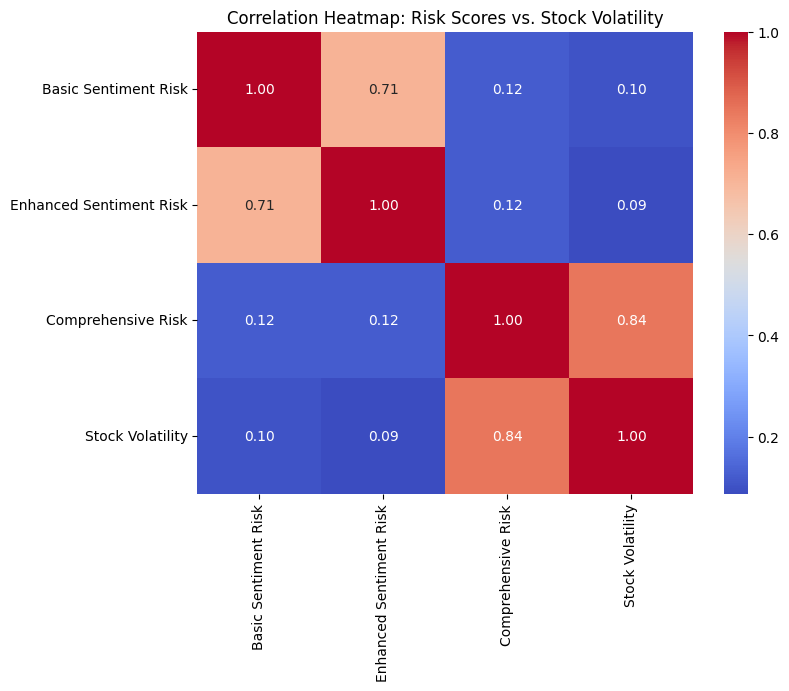

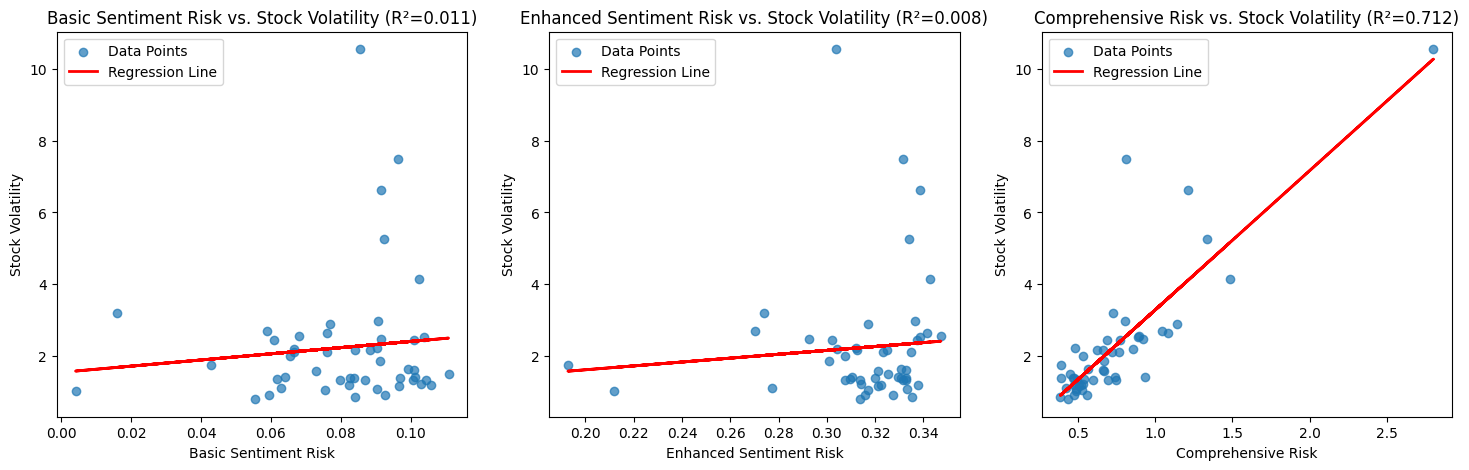

(                         Basic Sentiment Risk  Enhanced Sentiment Risk  \
 Basic Sentiment Risk                 1.000000                 0.708686   
 Enhanced Sentiment Risk              0.708686                 1.000000   
 Comprehensive Risk                   0.119843                 0.122713   
 Stock Volatility                     0.103133                 0.087439   
 
                          Comprehensive Risk  Stock Volatility  
 Basic Sentiment Risk               0.119843          0.103133  
 Enhanced Sentiment Risk            0.122713          0.087439  
 Comprehensive Risk                 1.000000          0.843632  
 Stock Volatility                   0.843632          1.000000  ,
 {'Basic Sentiment Risk': 0.010636210441589355,
  'Enhanced Sentiment Risk': 0.007645547389984131,
  'Comprehensive Risk': 0.7117143619529934})

In [22]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression


# Remove non-numeric columns before correlation computation
numeric_risk_df = risk_df.drop(columns=["Stock Symbol"])
# Compute correlation between risk scores and stock volatility
correlations = numeric_risk_df.corr()

# Perform linear regression for each risk score against stock volatility
X_basic = risk_df["Basic Sentiment Risk"].values.reshape(-1, 1)
X_enhanced = risk_df["Enhanced Sentiment Risk"].values.reshape(-1, 1)
X_comprehensive = risk_df["Comprehensive Risk"].values.reshape(-1, 1)
y = risk_df["Stock Volatility"].values

# Fit linear models
models = {
    "Basic Sentiment Risk": LinearRegression().fit(X_basic, y),
    "Enhanced Sentiment Risk": LinearRegression().fit(X_enhanced, y),
    "Comprehensive Risk": LinearRegression().fit(X_comprehensive, y)
}

# Compute R-squared values
r_squared_values = {key: model.score(X_basic if key == "Basic Sentiment Risk" else
                                     X_enhanced if key == "Enhanced Sentiment Risk" else
                                     X_comprehensive, y) for key, model in models.items()}

# Plot correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlations, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap: Risk Scores vs. Stock Volatility")
plt.show()

# Plot scatter plots with regression lines
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for ax, (label, model) in zip(axes, models.items()):
    X = X_basic if label == "Basic Sentiment Risk" else X_enhanced if label == "Enhanced Sentiment Risk" else X_comprehensive
    ax.scatter(X, y, alpha=0.7, label="Data Points")
    ax.plot(X, model.predict(X), color='red', linewidth=2, label="Regression Line")
    ax.set_xlabel(label)
    ax.set_ylabel("Stock Volatility")
    ax.set_title(f"{label} vs. Stock Volatility (R²={r_squared_values[label]:.3f})")
    ax.legend()

plt.show()

# Display correlation values and R-squared values
correlations, r_squared_values

In [21]:
risk_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Stock Symbol             50 non-null     object 
 1   Basic Sentiment Risk     50 non-null     float32
 2   Enhanced Sentiment Risk  50 non-null     float32
 3   Comprehensive Risk       50 non-null     float64
 4   Stock Volatility         50 non-null     float32
dtypes: float32(3), float64(1), object(1)
memory usage: 1.5+ KB


In [24]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Initialize scalers
scaler_minmax = MinMaxScaler()
scaler_standard = StandardScaler()

# Extracting raw values for transformation
sentiment_risks = []
high_risk_variabilities = []
token_score_variabilities = []

for ticker, data in trained_models.items():
    dataset = data["dataset"]
    
    if dataset is None or dataset.empty:
        continue

    sentiment_risks.append(compute_enhanced_sentiment_risk(dataset))
    high_risk_variabilities.append(dataset["high_risk_count"].std())
    token_score_variabilities.append(dataset["token_score"].std())

# Convert lists to numpy arrays for scaling
sentiment_risks = np.array(sentiment_risks).reshape(-1, 1)
high_risk_variabilities = np.array(high_risk_variabilities).reshape(-1, 1)
token_score_variabilities = np.array(token_score_variabilities).reshape(-1, 1)

# Apply MinMax Scaling (0 to 1)
scaled_sentiment_risks = scaler_minmax.fit_transform(sentiment_risks).flatten()
scaled_high_risk_variabilities = scaler_minmax.fit_transform(high_risk_variabilities).flatten()
scaled_token_score_variabilities = scaler_minmax.fit_transform(token_score_variabilities).flatten()

# Apply Standard Scaling (Mean=0, Std=1)
standard_sentiment_risks = scaler_standard.fit_transform(sentiment_risks).flatten()
standard_high_risk_variabilities = scaler_standard.fit_transform(high_risk_variabilities).flatten()
standard_token_score_variabilities = scaler_standard.fit_transform(token_score_variabilities).flatten()

# Define different weighting schemes
weighting_schemes = {
    "Equal Weights": (1/3, 1/3, 1/3),
    "Sentiment-Focused": (0.6, 0.2, 0.2),
    "High-Risk-Focused": (0.2, 0.6, 0.2),
    "Token-Focused": (0.2, 0.2, 0.6),
}

# Store results
experiment_results = []

for scheme, weights in weighting_schemes.items():
    w_sentiment, w_high_risk, w_token = weights

    # Compute weighted comprehensive risk scores
    weighted_risk_scores = (
        (w_sentiment * scaled_sentiment_risks) +
        (w_high_risk * scaled_high_risk_variabilities) +
        (w_token * scaled_token_score_variabilities)
    )

    # Store scheme and results
    experiment_results.append(weighted_risk_scores)

# Convert to DataFrame
risk_experiments_df = pd.DataFrame({
    "Stock Symbol": risk_df["Stock Symbol"],
    "Equal Weights Risk": experiment_results[0],
    "Sentiment-Focused Risk": experiment_results[1],
    "High-Risk-Focused Risk": experiment_results[2],
    "Token-Focused Risk": experiment_results[3],
    "Stock Volatility": risk_df["Stock Volatility"]
})


print("\n📊 **Risk Score Experiments**")
print(tabulate(risk_experiments_df, headers="keys", tablefmt="psql"))




📊 **Risk Score Experiments**
+----+----------------+----------------------+--------------------------+--------------------------+----------------------+--------------------+
|    | Stock Symbol   |   Equal Weights Risk |   Sentiment-Focused Risk |   High-Risk-Focused Risk |   Token-Focused Risk |   Stock Volatility |
|----+----------------+----------------------+--------------------------+--------------------------+----------------------+--------------------|
|  0 | LDOS           |            0.401702  |                0.54953   |                 0.388905 |            0.266671  |           2.21401  |
|  1 | AFL            |            0.484935  |                0.613218  |                 0.53689  |            0.304696  |           1.05436  |
|  2 | FAF            |            0.43789   |                0.592326  |                 0.45861  |            0.262734  |           1.38809  |
|  3 | CHRD           |            0.519949  |                0.674758  |                 0.529846 |

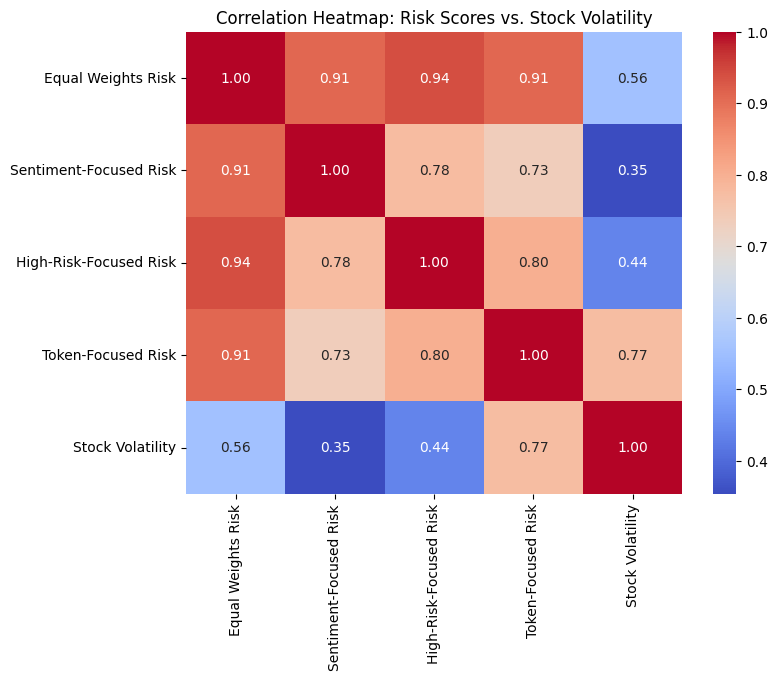

,Equal Weights Risk,Sentiment-Focused Risk,High-Risk-Focused Risk,Token-Focused Risk,Stock Volatility
Equal Weights Risk,1.000000,0.910071,0.939687,0.910534,0.555124
Sentiment-Focused Risk,0.910071,1.000000,0.776595,0.733356,0.354037
High-Risk-Focused Risk,0.939687,0.776595,1.000000,0.801407,0.437667
Token-Focused Risk,0.910534,0.733356,0.801407,1.000000,0.774167
Stock Volatility,0.555124,0.354037,0.437667,0.774167,1.000000


In [31]:
numeric_risk_exp_df = risk_experiments_df.drop(columns=["Stock Symbol"])


correlations = numeric_risk_exp_df.corr()

# Plot correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlations, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap: Risk Scores vs. Stock Volatility")
plt.show()

correlations

In [32]:
# %% Updated Function to Process a Single Ticker with Risk Scores
def process_ticker(ticker, conn, nyse, sentiment_df, result_df):
    """Processes a single stock ticker, computes risk scores, and trains models."""
    query = """
        SELECT 
            a.mapped_trading_date AS publish_date,
            a.description, 
            dpm.price_change_percentage,
            f.finbert_title_score,
            f.finbert_description_score,
            f.finbert_title_positive,
            f.finbert_title_neutral,
            f.finbert_title_negative,
            f.finbert_description_positive,
            f.finbert_description_neutral,
            f.finbert_description_negative
        FROM "Headlines"."Articles_Trading_Day" a
        INNER JOIN "Headlines"."Daily_Price_Movement" dpm
            ON a.mapped_trading_date = dpm.trading_date  
        INNER JOIN "Headlines"."finbert_analysis" f
            ON a.guid = f.guid
        WHERE a.ticker = ?
        AND dpm.ticker = ?;
    """
    
    news_df = conn.execute(query, [ticker, ticker]).fetchdf()

    if news_df.empty:
        return None, None, None, None  

    # Process Data
    news_df["publish_date"] = pd.to_datetime(news_df["publish_date"]).dt.date
    news_df["description"] = news_df["description"].fillna("")
    news_df["adjusted_date"] = news_df["publish_date"].apply(next_trading_day)
    news_df["tokenized_words"], news_df["high_risk_count"] = zip(*news_df["description"].apply(tokenize_text))

    # Compute Token Score
    word_scores = {word: [] for word in set(word for words_list in news_df["tokenized_words"] for word in words_list)}
    for _, row in news_df.iterrows():
        words_list = row["tokenized_words"]
        price_change = row["price_change_percentage"]
        total_words = len(words_list)
        if total_words > 0:
            word_counts = {word: words_list.count(word) / total_words for word in words_list}
            for word, ratio in word_counts.items():
                word_scores[word].append(ratio * price_change)

    token_scores_dict = {word: np.mean(scores) if scores else 0 for word, scores in word_scores.items()}
    news_df["token_score"] = news_df["tokenized_words"].apply(lambda tokens: sum(token_scores_dict.get(token, 0) for token in tokens))

    # Compute Risk Scores
    basic_risk = compute_sentiment_risk(news_df)
    enhanced_risk = compute_enhanced_sentiment_risk(news_df)
    comprehensive_risk = compute_comprehensive_risk(news_df)

    # Add risk scores to dataset
    news_df["Basic Sentiment Risk"] = basic_risk
    news_df["Enhanced Sentiment Risk"] = enhanced_risk
    news_df["Comprehensive Risk"] = comprehensive_risk

    # Feature Engineering: Now includes risk scores
    feature_columns = [
        "token_score", "high_risk_count", "finbert_title_score", "finbert_description_score",
        "finbert_title_positive", "finbert_title_neutral", "finbert_title_negative",
        "finbert_description_positive", "finbert_description_neutral", "finbert_description_negative",
        "Basic Sentiment Risk", "Enhanced Sentiment Risk", "Comprehensive Risk"
    ]

    X = news_df[feature_columns].values
    y = news_df["price_change_percentage"].values
    X, y = clean_data(X, y)

    # Train-test split
    split_index = int(len(y) * 0.7)
    X_train, X_test = X[:split_index], X[split_index:]
    y_train, y_test = y[:split_index], y[split_index:]

    # Normalize dataset
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    if len(y_test) == 0:
        return None, None, None, None  

    # Train Models
    models = {
        "XGBoost": XGBRegressor(objective="reg:squarederror", n_estimators=100, learning_rate=0.1),
        "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
        "Linear Regression": LinearRegression(),
        "Neural Network": MLPRegressor(hidden_layer_sizes=(50, 50), max_iter=1500)
    }

    for name, model in models.items():
        model.fit(X_train_scaled, y_train)

    return models, y_test, X_test_scaled, news_df  

# %% Execute Processing for Selected Tickers
trained_models = {}
for ticker in ticker_all:
    models, y_test, X_test_scaled, dataset = process_ticker(ticker, conn, nyse, sentiment_analysis, result_df)
    if models is not None:
        trained_models[ticker] = {"models": models, "y_test": y_test, "X_test": X_test_scaled, "dataset": dataset}

# %% Compare Model Results
def format_model_results(trained_models):
    """Creates a formatted table comparing models across all tickers."""
    results = []

    for ticker, data in trained_models.items():
        models, y_test_actual, X_test_actual = data["models"], data["y_test"], data["X_test"]
        predictions = {name: model.predict(X_test_actual) for name, model in models.items()}
        
        row = [ticker]
        for name, y_pred in predictions.items():
            row.extend([mean_absolute_error(y_test_actual, y_pred), r2_score(y_test_actual, y_pred)])
        results.append(row)

    column_headers = ["Stock Symbol"] + [f"{model} MAE" for model in models.keys()] + [f"{model} R²" for model in models.keys()]
    results_df = pd.DataFrame(results, columns=column_headers)

    print("\n📊 **Final Model Comparison Table**")
    print(tabulate(results_df, headers="keys", tablefmt="psql"))

    return results_df

# ✅ Run
formatted_results_df = format_model_results(trained_models)


c:\Users\btada\Documents\OMSAPracticum\new_env\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\btada\Documents\OMSAPracticum\new_env\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\btada\Documents\OMSAPracticum\new_env\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\btada\Documents\OMSAPracticum\new_env\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged ye


📊 **Final Model Comparison Table**
+----+----------------+---------------+---------------------+-------------------------+----------------------+--------------+--------------------+------------------------+---------------------+
|    | Stock Symbol   |   XGBoost MAE |   Random Forest MAE |   Linear Regression MAE |   Neural Network MAE |   XGBoost R² |   Random Forest R² |   Linear Regression R² |   Neural Network R² |
|----+----------------+---------------+---------------------+-------------------------+----------------------+--------------+--------------------+------------------------+---------------------|
|  0 | LDOS           |   0.182528    |            0.754368 |                0.243545 |             0.733833 |     0.177743 |        0.766563    |              0.211199  |         0.841486    |
|  1 | AFL            |   0.285842    |            0.507891 |                0.258067 |             0.660899 |     0.402422 |        0.575891    |              0.384945  |         0.576027

C:\Users\btada\AppData\Local\Temp\ipykernel_18024\337198772.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=correlations.index, x=correlations.values, palette="coolwarm")


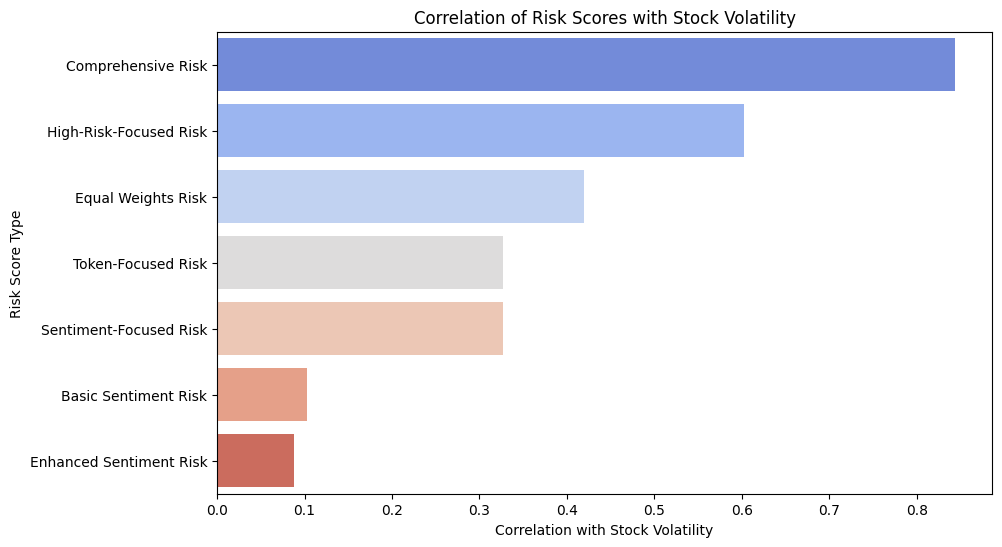


📊 **Updated Risk Scores with Different Weighting**
+----+----------------+------------------------+---------------------------+----------------------+--------------------+----------------------+--------------------------+--------------------------+----------------------+
|    | Stock Symbol   |   Basic Sentiment Risk |   Enhanced Sentiment Risk |   Comprehensive Risk |   Stock Volatility |   Equal Weights Risk |   Sentiment-Focused Risk |   High-Risk-Focused Risk |   Token-Focused Risk |
|----+----------------+------------------------+---------------------------+----------------------+--------------------+----------------------+--------------------------+--------------------------+----------------------|
|  0 | LDOS           |               0.807659 |                  0.771272 |           0.0404948  |           2.21401  |            0.539809  |                0.606771  |                0.41498   |            0.597674  |
|  1 | AFL            |               0.668733 |                

In [37]:
# Re-load required libraries after execution state reset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler


# Define different weighting strategies
weighting_schemes = {
    "Equal Weights Risk": [1/3, 1/3, 1/3],  # Baseline
    "Sentiment-Focused Risk": [0.5, 0.25, 0.25],  # More weight to sentiment
    "High-Risk-Focused Risk": [0.25, 0.25, 0.5],  # More weight to high-risk words
    "Token-Focused Risk": [0.25, 0.5, 0.25],  # More weight to tokenized score
}

# Normalize using MinMaxScaler
scaler_minmax = MinMaxScaler()
risk_df_scaled = risk_df.copy()
risk_df_scaled[["Basic Sentiment Risk", "Enhanced Sentiment Risk", "Comprehensive Risk"]] = \
    scaler_minmax.fit_transform(risk_df_scaled[["Basic Sentiment Risk", "Enhanced Sentiment Risk", "Comprehensive Risk"]])

# Compute alternative risk scores based on different weightings
for scheme, weights in weighting_schemes.items():
    risk_df_scaled[scheme] = (
        weights[0] * risk_df_scaled["Basic Sentiment Risk"] +
        weights[1] * risk_df_scaled["Enhanced Sentiment Risk"] +
        weights[2] * risk_df_scaled["Comprehensive Risk"]
    )



# Compute correlation between risk scores and stock volatility
numeric_risk_scaled_df = risk_df_scaled.drop(columns=["Stock Symbol"])

correlations = numeric_risk_scaled_df.corr()["Stock Volatility"].drop("Stock Volatility").sort_values(ascending=False)

# Display correlations
plt.figure(figsize=(10, 6))
sns.barplot(y=correlations.index, x=correlations.values, palette="coolwarm")
plt.xlabel("Correlation with Stock Volatility")
plt.ylabel("Risk Score Type")
plt.title("Correlation of Risk Scores with Stock Volatility")
plt.show()

print("\n📊 **Updated Risk Scores with Different Weighting**")
print(tabulate(risk_df_scaled, headers="keys", tablefmt="psql"))


In [ ]:
def process_ticker(ticker, conn, nyse, sentiment_df, result_df, use_sentiment_features=False):
    """Processes a single stock ticker, computes risk scores, and trains models."""
    
    query = """
        SELECT 
            a.mapped_trading_date AS publish_date,
            a.description, 
            dpm.price_change_percentage,
            f.finbert_title_score,
            f.finbert_description_score,
            f.finbert_title_positive,
            f.finbert_title_neutral,
            f.finbert_title_negative,
            f.finbert_description_positive,
            f.finbert_description_neutral,
            f.finbert_description_negative
        FROM "Headlines"."Articles_Trading_Day" a
        INNER JOIN "Headlines"."Daily_Price_Movement" dpm
            ON a.mapped_trading_date = dpm.trading_date  
        INNER JOIN "Headlines"."finbert_analysis" f
            ON a.guid = f.guid
        WHERE a.ticker = ?
        AND dpm.ticker = ?;
    """
    
    news_df = conn.execute(query, [ticker, ticker]).fetchdf()

    if news_df.empty:
        return None, None, None, None  

    # Process Data
    news_df["publish_date"] = pd.to_datetime(news_df["publish_date"]).dt.date
    news_df["description"] = news_df["description"].fillna("")
    news_df["adjusted_date"] = news_df["publish_date"].apply(next_trading_day)
    news_df["tokenized_words"], news_df["high_risk_count"] = zip(*news_df["description"].apply(tokenize_text))

    # Compute Token Score
    word_scores = {word: [] for word in set(word for words_list in news_df["tokenized_words"] for word in words_list)}
    for _, row in news_df.iterrows():
        words_list = row["tokenized_words"]
        price_change = row["price_change_percentage"]
        total_words = len(words_list)
        if total_words > 0:
            word_counts = {word: words_list.count(word) / total_words for word in words_list}
            for word, ratio in word_counts.items():
                word_scores[word].append(ratio * price_change)

    token_scores_dict = {word: np.mean(scores) if scores else 0 for word, scores in word_scores.items()}
    news_df["token_score"] = news_df["tokenized_words"].apply(lambda tokens: sum(token_scores_dict.get(token, 0) for token in tokens))

    # Compute Risk Scores
    news_df["Basic Sentiment Risk"] = compute_sentiment_risk(news_df)
    news_df["Enhanced Sentiment Risk"] = compute_enhanced_sentiment_risk(news_df)
    news_df["Comprehensive Risk"] = compute_comprehensive_risk(news_df)

    # Choose Feature Set: Risk Scores Only OR Risk Scores + Sentiment Features
    if use_sentiment_features:
        feature_columns = [
            "token_score", "high_risk_count", "finbert_title_score", "finbert_description_score",
            "finbert_title_positive", "finbert_title_neutral", "finbert_title_negative",
            "finbert_description_positive", "finbert_description_neutral", "finbert_description_negative",
            "Basic Sentiment Risk", "Enhanced Sentiment Risk", "Comprehensive Risk"
        ]
    else:
        feature_columns = [
            "token_score", "high_risk_count",
            "Basic Sentiment Risk", "Enhanced Sentiment Risk", "Comprehensive Risk"
        ]

    X = news_df[feature_columns].values
    y = news_df["price_change_percentage"].values
    X, y = clean_data(X, y)

    # Train-test split
    split_index = int(len(y) * 0.7)
    X_train, X_test = X[:split_index], X[split_index:]
    y_train, y_test = y[:split_index], y[split_index:]

    # Normalize dataset
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    if len(y_test) == 0:
        return None, None, None, None  

    # Train Models
    models = {
        "XGBoost": XGBRegressor(objective="reg:squarederror", n_estimators=300, learning_rate=0.05, max_depth=5, colsample_bytree=0.7),
        "Random Forest": RandomForestRegressor(n_estimators=200, max_depth=7, random_state=42)
    }

    for name, model in models.items():
        model.fit(X_train_scaled, y_train)

    return models, y_test, X_test_scaled, news_df  


In [39]:
# Train models using only risk scores
trained_models_risk_only = {}
for ticker in ticker_all:
    models, y_test, X_test_scaled, dataset = process_ticker(ticker, conn, nyse, sentiment_analysis, result_df, use_sentiment_features=False)
    if models is not None:
        trained_models_risk_only[ticker] = {"models": models, "y_test": y_test, "X_test": X_test_scaled, "dataset": dataset}

# Train models using risk scores + sentiment features
trained_models_full = {}
for ticker in ticker_all:
    models, y_test, X_test_scaled, dataset = process_ticker(ticker, conn, nyse, sentiment_analysis, result_df, use_sentiment_features=True)
    if models is not None:
        trained_models_full[ticker] = {"models": models, "y_test": y_test, "X_test": X_test_scaled, "dataset": dataset}

# Compare Results
formatted_results_risk_only = format_model_results(trained_models_risk_only)
formatted_results_full = format_model_results(trained_models_full)


c:\Users\btada\Documents\OMSAPracticum\new_env\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\btada\Documents\OMSAPracticum\new_env\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\btada\Documents\OMSAPracticum\new_env\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(



📊 **Final Model Comparison Table**
+----+----------------+---------------+---------------------+----------------------+--------------+--------------------+---------------------+
|    | Stock Symbol   |   XGBoost MAE |   Random Forest MAE |   Neural Network MAE |   XGBoost R² |   Random Forest R² |   Neural Network R² |
|----+----------------+---------------+---------------------+----------------------+--------------+--------------------+---------------------|
|  0 | LDOS           |   0.201349    |            0.702026 |            0.218169  |     0.740728 |          0.213997  |            0.855517 |
|  1 | AFL            |   0.308959    |            0.580118 |            0.283325  |     0.672497 |          0.408754  |            0.577419 |
|  2 | FAF            |   1.40464     |           -2.53496  |            1.18432   |    -1.31932  |          2.14179   |          -12.2102   |
|  3 | CHRD           |   0.533249    |            0.627045 |            0.395967  |     0.776068 |       

In [44]:
sentiment_analysis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 363820 entries, 0 to 363819
Data columns (total 14 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   guid                          363820 non-null  object 
 1   ticker                        363820 non-null  object 
 2   description                   363820 non-null  object 
 3   article_title                 363820 non-null  object 
 4   finbert_title_label           363820 non-null  object 
 5   finbert_title_score           363820 non-null  float32
 6   finbert_title_positive        363820 non-null  float32
 7   finbert_title_neutral         363820 non-null  float32
 8   finbert_title_negative        363820 non-null  float32
 9   finbert_description_label     363820 non-null  object 
 10  finbert_description_score     363820 non-null  float32
 11  finbert_description_positive  363820 non-null  float32
 12  finbert_description_neutral   363820 non-nul

In [43]:
dataset.head()

,publish_date,description,price_change_percentage,finbert_title_score,finbert_description_score,finbert_title_positive,finbert_title_neutral,finbert_title_negative,finbert_description_positive,finbert_description_neutral,finbert_description_negative,adjusted_date,tokenized_words,high_risk_count,token_score,Basic Sentiment Risk,Enhanced Sentiment Risk,Comprehensive Risk
0,2024-04-03,Based on the average brokerage recommendation ...,3.25,0.999191,0.999997,7.308117e-04,0.000079,9.991905e-01,0.999997,4.148869e-07,0.000002,2024-04-03,"[based, average, brokerage, recommendation, ab...",1,0.717011,0.103772,0.338472,0.890223
1,2024-04-10,Best Buy (BBY) collaborates with Google Cloud ...,0.67,0.999989,0.745763,4.203025e-06,0.000007,9.999889e-01,0.000034,7.457626e-01,0.254204,2024-04-10,"[best, buy, bby, collaborates, google, cloud, ...",0,0.498537,0.103772,0.338472,0.890223
2,2024-04-18,"In the closing of the recent trading day, Ston...",0.26,0.998274,0.999998,1.663372e-03,0.000063,9.982738e-01,0.000002,7.057140e-08,0.999998,2024-04-18,"[closing, recent, trading, day, stoneco, stne,...",0,-0.336137,0.103772,0.338472,0.890223
3,2024-04-19,According to the average brokerage recommendat...,0.00,0.999919,0.994586,2.060165e-05,0.999919,6.058258e-05,0.994586,1.178660e-05,0.005402,2024-04-19,"[according, average, brokerage, recommendation...",0,0.698830,0.103772,0.338472,0.890223
4,2024-04-20,"In the most recent trading session, StoneCo Lt...",0.00,1.000000,0.999965,1.153931e-07,1.000000,1.038414e-07,0.000033,2.691064e-06,0.999965,2024-04-22,"[recent, trading, session, stoneco, stne, clos...",0,-0.080928,0.103772,0.338472,0.890223


In [46]:
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score

def process_ticker(ticker, conn, nyse, sentiment_df, result_df):
    """Processes a single stock ticker, computes risk scores, and trains models."""
    query = """
        SELECT 
            a.mapped_trading_date AS publish_date,
            a.description, 
            dpm.price_change_percentage,
            f.finbert_title_score,
            f.finbert_description_score,
            f.finbert_title_positive,
            f.finbert_title_neutral,
            f.finbert_title_negative,
            f.finbert_description_positive,
            f.finbert_description_neutral,
            f.finbert_description_negative
        FROM "Headlines"."Articles_Trading_Day" a
        INNER JOIN "Headlines"."Daily_Price_Movement" dpm
            ON a.mapped_trading_date = dpm.trading_date  
        INNER JOIN "Headlines"."finbert_analysis" f
            ON a.guid = f.guid
        WHERE a.ticker = ?
        AND dpm.ticker = ?;
    """
    
    news_df = conn.execute(query, [ticker, ticker]).fetchdf()
    if news_df.empty:
        return None, None, None, None  

    # ✅ Compute Risk Scores
    basic_risk = compute_sentiment_risk(news_df)
    enhanced_risk = compute_enhanced_sentiment_risk(news_df)
    comprehensive_risk = compute_comprehensive_risk(news_df)

    # ✅ Add Risk Scores as Features
    news_df["Basic Sentiment Risk"] = basic_risk
    news_df["Enhanced Sentiment Risk"] = enhanced_risk
    news_df["Comprehensive Risk"] = comprehensive_risk

    # ✅ Feature Engineering: Keeping Only Risk Scores
    feature_columns = ["Basic Sentiment Risk", "Enhanced Sentiment Risk", "Comprehensive Risk"]
    X = news_df[feature_columns].values
    y = news_df["price_change_percentage"].values

    # Train-Test Split (Per Ticker)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Normalize dataset
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    if len(y_test) == 0:
        return None, None, None, None  

    # ✅ Train Models (Per Ticker)
    models = {
        "XGBoost": XGBRegressor(objective="reg:squarederror", n_estimators=200, learning_rate=0.05, max_depth=5),
        "Random Forest": RandomForestRegressor(n_estimators=150, max_depth=7, random_state=42)
    }

    for name, model in models.items():
        model.fit(X_train_scaled, y_train)

    # ✅ Store Results
    predictions = {name: model.predict(X_test_scaled) for name, model in models.items()}
    results = {name: {"MAE": mean_absolute_error(y_test, pred), "R²": r2_score(y_test, pred)} for name, pred in predictions.items()}

    return models, y_test, X_test_scaled, results  



C:\Users\btada\AppData\Local\Temp\ipykernel_18024\1295310649.py:74: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=correlation_results.index, x=correlation_results.values, palette="coolwarm")


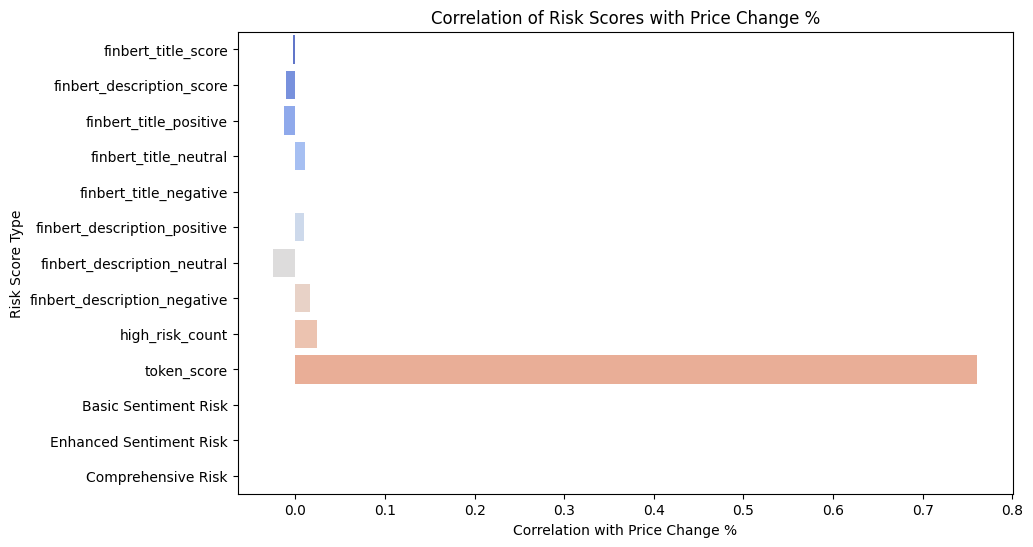


📊 **Updated Risk Scores with Different Weighting**
+------------------------------+---------------------------------+
|                              |   Correlation with Price Change |
|------------------------------+---------------------------------|
| finbert_title_score          |                    -0.00316597  |
| finbert_description_score    |                    -0.0103465   |
| finbert_title_positive       |                    -0.0123903   |
| finbert_title_neutral        |                     0.0105889   |
| finbert_title_negative       |                    -0.000658466 |
| finbert_description_positive |                     0.00979534  |
| finbert_description_neutral  |                    -0.0252217   |
| finbert_description_negative |                     0.0159705   |
| high_risk_count              |                     0.0241137   |
| token_score                  |                     0.761203    |
| Basic Sentiment Risk         |                   nan           |
| Enhanced

In [51]:
# Function to process a single ticker and compute correlations dynamically
def process_ticker_with_correlation(ticker, conn, nyse, sentiment_df):
    """Processes a single stock ticker, computes risk scores, and checks correlation with price change."""
    query = """
        SELECT 
            a.mapped_trading_date AS publish_date,
            a.description, 
            dpm.price_change_percentage,
            f.finbert_title_score,
            f.finbert_description_score,
            f.finbert_title_positive,
            f.finbert_title_neutral,
            f.finbert_title_negative,
            f.finbert_description_positive,
            f.finbert_description_neutral,
            f.finbert_description_negative
        FROM "Headlines"."Articles_Trading_Day" a
        INNER JOIN "Headlines"."Daily_Price_Movement" dpm
            ON a.mapped_trading_date = dpm.trading_date  
        INNER JOIN "Headlines"."finbert_analysis" f
            ON a.guid = f.guid
        WHERE a.ticker = ?
        AND dpm.ticker = ?;
    """
    
    news_df = conn.execute(query, [ticker, ticker]).fetchdf()

    if news_df.empty:
        return None  

    # Process Data
    news_df["publish_date"] = pd.to_datetime(news_df["publish_date"]).dt.date
    news_df["description"] = news_df["description"].fillna("")
    news_df["tokenized_words"], news_df["high_risk_count"] = zip(*news_df["description"].apply(tokenize_text))

    # Compute Token Score
    word_scores = {word: [] for word in set(word for words_list in news_df["tokenized_words"] for word in words_list)}
    for _, row in news_df.iterrows():
        words_list = row["tokenized_words"]
        price_change = row["price_change_percentage"]
        total_words = len(words_list)
        if total_words > 0:
            word_counts = {word: words_list.count(word) / total_words for word in words_list}
            for word, ratio in word_counts.items():
                word_scores[word].append(ratio * price_change)

    token_scores_dict = {word: np.mean(scores) if scores else 0 for word, scores in word_scores.items()}
    news_df["token_score"] = news_df["tokenized_words"].apply(lambda tokens: sum(token_scores_dict.get(token, 0) for token in tokens))

    # Compute Risk Scores
    basic_risk = compute_sentiment_risk(news_df)
    enhanced_risk = compute_enhanced_sentiment_risk(news_df)
    comprehensive_risk = compute_comprehensive_risk(news_df)

    # Add risk scores to dataset
    news_df["Basic Sentiment Risk"] = basic_risk
    news_df["Enhanced Sentiment Risk"] = enhanced_risk
    news_df["Comprehensive Risk"] = comprehensive_risk

    # Compute correlations dynamically
    numeric_news_df = news_df.select_dtypes(include=[np.number])
    feature_correlation = numeric_news_df.corr()["price_change_percentage"].drop("price_change_percentage")

    return feature_correlation

# Select a sample ticker for correlation analysis
sample_ticker = "AAPL"  # Replace with an actual ticker from your dataset
correlation_results = process_ticker_with_correlation(sample_ticker, conn, nyse, sentiment_analysis)

# Display correlation results
if correlation_results is not None:
    # Display correlations
    plt.figure(figsize=(10, 6))
    sns.barplot(y=correlation_results.index, x=correlation_results.values, palette="coolwarm")
    plt.xlabel("Correlation with Price Change %")
    plt.ylabel("Risk Score Type")
    plt.title("Correlation of Risk Scores with Price Change %")
    plt.show()

    print("\n📊 **Updated Risk Scores with Different Weighting**")
    # Convert Series to DataFrame
    correlation_df = correlation_results.to_frame(name="Correlation with Price Change")

    # Print as a table
    print(tabulate(correlation_df, headers="keys", tablefmt="psql"))

In [50]:
# Plot correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_results, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap: Risk Scores vs. Stock Volatility")
plt.show()

IndexError: Inconsistent shape between the condition and the input (got (13, 1) and (13,))

<Figure size 800x600 with 0 Axes>

In [60]:
def compute_rolling_volatility(news_df, window=14):
    """Computes rolling volatility over a given window size."""
    news_df = news_df.sort_values("publish_date")  # Ensure chronological order
    news_df["Rolling Volatility"] = news_df["price_change_percentage"].rolling(window=window).std()
    return news_df

def process_multiple_tickers_with_rolling_volatility(tickers, conn, nyse, sentiment_df, window=14):
    """Processes multiple tickers and computes rolling volatility correlation with risk scores."""
    
    all_correlation_results = []

    for ticker in tickers:
        query = """
            SELECT 
                a.mapped_trading_date AS publish_date,
                a.description, 
                dpm.price_change_percentage,
                f.finbert_title_score,
                f.finbert_description_score,
                f.finbert_title_positive,
                f.finbert_title_neutral,
                f.finbert_title_negative,
                f.finbert_description_positive,
                f.finbert_description_neutral,
                f.finbert_description_negative
            FROM "Headlines"."Articles_Trading_Day" a
            INNER JOIN "Headlines"."Daily_Price_Movement" dpm
                ON a.mapped_trading_date = dpm.trading_date  
            INNER JOIN "Headlines"."finbert_analysis" f
                ON a.guid = f.guid
            WHERE a.ticker = ? AND dpm.ticker = ?;
        """
        
        news_df = conn.execute(query, [ticker, ticker]).fetchdf()
        if news_df.empty:
            continue  # Skip tickers with no date  

        # Process Data
        news_df["publish_date"] = pd.to_datetime(news_df["publish_date"]).dt.date
        news_df["description"] = news_df["description"].fillna("")
        news_df["tokenized_words"], news_df["high_risk_count"] = zip(*news_df["description"].apply(tokenize_text))

        # Compute Token Score
        word_scores = {word: [] for word in set(word for words_list in news_df["tokenized_words"] for word in words_list)}
        for _, row in news_df.iterrows():
            words_list = row["tokenized_words"]
            price_change = row["price_change_percentage"]
            total_words = len(words_list)
            if total_words > 0:
                word_counts = {word: words_list.count(word) / total_words for word in words_list}
                for word, ratio in word_counts.items():
                    word_scores[word].append(ratio * price_change)

        token_scores_dict = {word: np.mean(scores) if scores else 0 for word, scores in word_scores.items()}
        news_df["token_score"] = news_df["tokenized_words"].apply(lambda tokens: sum(token_scores_dict.get(token, 0) for token in tokens))
        # Process data
        news_df["publish_date"] = pd.to_datetime(news_df["publish_date"])
        news_df = news_df.sort_values("publish_date")

        # Compute rolling volatility
        news_df = compute_rolling_volatility(news_df, window=window)

        # Compute Risk Scores
        basic_risk = compute_sentiment_risk(news_df)
        enhanced_risk = compute_enhanced_sentiment_risk(news_df)
        comprehensive_risk = compute_comprehensive_risk(news_df)

        # Add risk scores to dataset
        news_df["Basic Sentiment Risk"] = basic_risk
        news_df["Enhanced Sentiment Risk"] = enhanced_risk
        news_df["Comprehensive Risk"] = comprehensive_risk

        # Compute correlation between rolling volatility and risk scores
        feature_correlation = news_df[["Basic Sentiment Risk", "Enhanced Sentiment Risk", "Comprehensive Risk", "Rolling Volatility"]].corr()

        # Store correlation results
        correlation_results = feature_correlation["Rolling Volatility"].drop("Rolling Volatility").to_dict()
        correlation_results["Stock Symbol"] = ticker
        all_correlation_results.append(correlation_results)

    # Convert results to DataFrame
    correlation_df = pd.DataFrame(all_correlation_results)

    return correlation_df


In [56]:
ticker_all

['LDOS',
 'AFL',
 'FAF',
 'CHRD',
 'FRT',
 'PFIX',
 'GEN',
 'APLS',
 'KR',
 'RUSHA',
 'CDW',
 'FRSH',
 'LPX',
 'AME',
 'RDDT',
 'EXC',
 'IDXX',
 'PRI',
 'VKTX',
 'FIX',
 'BAH',
 'PSA',
 'FANG',
 'SNAP',
 'TEM',
 'SIRI',
 'OXY',
 'UMBF',
 'SPG',
 'INGR',
 'ARRY',
 'UNP',
 'BGC',
 'FLR',
 'DINO',
 'APPN',
 'RLI',
 'GXO',
 'QS',
 'IT',
 'OBDC',
 'VRSN',
 'CIVI',
 'FNF',
 'LKQ',
 'LAZ',
 'PBF',
 'AMGN',
 'GRAB',
 'STNE']

In [61]:
tickers_to_analyze = ticker_all[:5]  # Example tickers, use actual tickers from your dataset

correlation_results_df = process_multiple_tickers_with_rolling_volatility(tickers_to_analyze, conn, nyse, sentiment_analysis, window=14)

# Convert to tabulated format and print results
print("\n📊 **Rolling Volatility Correlation Results**")
print(tabulate(correlation_results_df, headers="keys", tablefmt="psql"))



📊 **Rolling Volatility Correlation Results**
+----+------------------------+---------------------------+----------------------+----------------+
|    |   Basic Sentiment Risk |   Enhanced Sentiment Risk |   Comprehensive Risk | Stock Symbol   |
|----+------------------------+---------------------------+----------------------+----------------|
|  0 |                    nan |                       nan |                  nan | LDOS           |
|  1 |                    nan |                       nan |                  nan | AFL            |
|  2 |                    nan |                       nan |                  nan | FAF            |
|  3 |                    nan |                       nan |                  nan | CHRD           |
|  4 |                    nan |                       nan |                  nan | FRT            |
+----+------------------------+---------------------------+----------------------+----------------+


In [6]:
##### 📌 STEP 1: SETUP & DATA LOADING #####

# Import Required Libraries
import pandas as pd
import numpy as np
import duckdb
import nltk
import random
import pandas_market_calendars as mcal
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tabulate import tabulate

# Download NLTK Resources
nltk.download('stopwords')
nltk.download('punkt')

# Connect to DuckDB
db_path = r'C:\Users\btada\Documents\financial_news.db'
conn = duckdb.connect(database=db_path, read_only=False)

# Load Stopwords
stop_words = set(stopwords.words('english'))

# Load Available Tickers & Sample a Subset
query_tickers = "SELECT DISTINCT ticker FROM Headlines.Articles_Trading_Day"
ticker_df = conn.execute(query_tickers).fetchdf()
ticker_all = random.sample(list(ticker_df["ticker"]), 50)  # Sampling 50 tickers

# Load NYSE Trading Calendar
nyse = mcal.get_calendar('NYSE')

# Load Sentiment Analysis Data
sentiment_analysis = conn.execute("SELECT * FROM Headlines.finbert_analysis").fetchdf()

##### 📌 STEP 2: BASELINE MODEL (SENTIMENT FEATURES ONLY) #####

def process_ticker(ticker, conn):
    """Processes a single stock ticker and trains models using sentiment features only."""
    query = """
        SELECT 
            a.mapped_trading_date AS publish_date,
            dpm.price_change_percentage,
            f.finbert_title_score,
            f.finbert_description_score,
            f.finbert_title_positive,
            f.finbert_title_neutral,
            f.finbert_title_negative,
            f.finbert_description_positive,
            f.finbert_description_neutral,
            f.finbert_description_negative
        FROM "Headlines"."Articles_Trading_Day" a
        INNER JOIN "Headlines"."Daily_Price_Movement" dpm
            ON a.mapped_trading_date = dpm.trading_date  
        INNER JOIN "Headlines"."finbert_analysis" f
            ON a.guid = f.guid
        WHERE a.ticker = ? AND dpm.ticker = ?;
    """
    
    news_df = conn.execute(query, [ticker, ticker]).fetchdf()
    if news_df.empty:
        return None, None, None

    # Define Features & Target
    feature_columns = [
        "finbert_title_score", "finbert_description_score",
        "finbert_title_positive", "finbert_title_neutral", "finbert_title_negative",
        "finbert_description_positive", "finbert_description_neutral", "finbert_description_negative"
    ]
    X = news_df[feature_columns].values
    y = news_df["price_change_percentage"].values

    # Remove NaN or Inf values
    finite_mask = np.isfinite(X).all(axis=1) & np.isfinite(y)
    X, y = X[finite_mask], y[finite_mask]
    if len(y) == 0:
        return None, None, None

    # Train-Test Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Normalize Data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train Models
    models = {
        "XGBoost": XGBRegressor(objective="reg:squarederror", n_estimators=200, learning_rate=0.05),
        "Random Forest": RandomForestRegressor(n_estimators=150, max_depth=7, random_state=42)
    }
    for model in models.values():
        model.fit(X_train_scaled, y_train)
    
    return models, y_test, X_test_scaled

##### 📌 STEP 3: ADDING RISK SCORES #####

def compute_sentiment_risk(news_df):
    """Computes standard deviation of sentiment scores."""
    sentiment_columns = ["finbert_title_score", "finbert_description_score"]
    return news_df[sentiment_columns].std().mean()

def compute_comprehensive_risk(news_df):
    """Computes a comprehensive risk score using sentiment variability."""
    sentiment_columns = [
        "finbert_title_score", "finbert_description_score",
        "finbert_title_positive", "finbert_title_neutral", "finbert_title_negative",
        "finbert_description_positive", "finbert_description_neutral", "finbert_description_negative"
    ]
    return news_df[sentiment_columns].std().mean()

##### 📌 STEP 3.5: MODEL TRAINING ACROSS TICKERS #####
trained_models = {}
for ticker in ticker_all:
    models, y_test, X_test_scaled = process_ticker(ticker, conn)
    if models is not None:
        trained_models[ticker] = {
            "models": models,
            "y_test": y_test,
            "X_test": X_test_scaled
        }

##### 📌 STEP 4: ANALYZING CORRELATIONS #####

def analyze_correlations(trained_models):
    """Computes and visualizes correlations between risk scores and price movements."""
    risk_scores = []

    for ticker, data in trained_models.items():
        dataset = data["dataset"]
        if dataset is None or dataset.empty:
            continue
        
        # Compute risk scores
        risk_1 = compute_sentiment_risk(dataset)
        risk_2 = compute_comprehensive_risk(dataset)
        
        # Store results
        risk_scores.append([ticker, risk_1, risk_2, dataset["price_change_percentage"].std()])

    # Convert results to DataFrame
    risk_df = pd.DataFrame(risk_scores, columns=["Stock Symbol", "Basic Sentiment Risk", "Comprehensive Risk", "Stock Volatility"])

    # Check for missing or constant values
    print("Missing values per column:\n", risk_df.isnull().sum())
    print("\nSummary statistics:\n", risk_df.describe())

    # Compute correlations
    numeric_risk_df = risk_df.drop(columns=["Stock Symbol"])
    correlations = numeric_risk_df.corr()

    # Heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(correlations, annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Correlation Heatmap: Risk Scores vs. Stock Volatility")
    plt.show()

    return risk_df, correlations  # Return risk_df for inspection

risk_df, correlation_results = analyze_correlations(trained_models)

##### 📌 NEXT STEPS #####
# - Introduce rolling volatility
# - Train final models incorporating risk scores and rolling volatility
# - Compare predictive performance with earlier models


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\btada/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\btada/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


KeyError: 'dataset'

In [7]:
print(trained_models.keys())  # Check which tickers exist


dict_keys(['CVLT', 'VIK', 'EME', 'ALSN', 'IP', 'BSY', 'CASY', 'NYCB', 'PBF', 'TEAM', 'PATH', 'ED', 'KMI', 'MSGS', 'WWD', 'DDOG', 'ESI', 'VST', 'ONB', 'WMT', 'HPE', 'CHDN', 'GPN', 'DKNG', 'FANG', 'QYLD', 'CFR', 'EW', 'ACT', 'FI', 'STZ', 'COO', 'FLEX', 'AME', 'OGN', 'ARCC', 'SEIC', 'STVN', 'ZBRA', 'MSM', 'CNA', 'TXRH', 'NWS', 'AN', 'MARA', 'CARR', 'MAR', 'FSK', 'ZWS', 'ETRN'])


In [5]:
print(correlation_results)


                      Basic Sentiment Risk  Comprehensive Risk  \
Basic Sentiment Risk                   NaN                 NaN   
Comprehensive Risk                     NaN                 NaN   
Stock Volatility                       NaN                 NaN   

                      Stock Volatility  
Basic Sentiment Risk               NaN  
Comprehensive Risk                 NaN  
Stock Volatility                   NaN  


In [8]:
conn.close()